# Validation/Verification & Performance comparison for LOGIC gates with multiple hidden layers and multiple neurons

## Set ncores for my Implementation (needs to be before importing numpy)

In [1]:
nThreads = 8

### For Numpy MKL

In [2]:
! export OMP_NUM_THREADS=8 MKL_NUM_THREADS=8 NUMEXPR_NUM_THREADS=8
! export TF_NUM_INTEROP_THREADS=8

## Import stuff

In [1]:
import numpy as np
# print(np.__version__)
from autograd import numpy as anp
from autograd import grad, elementwise_grad, jacobian
from IPython import display
import time
from tqdm.notebook import tqdm
import numexpr as ne
from opt_einsum import contract, contract_expression
from numba import vectorize,jit,njit,prange,set_num_threads,get_num_threads 
from nnv import NNV
import matplotlib.pyplot as plt
from operator import add
# from numpy.core.umath_tests import inner1d


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.python.eager import context


import torch
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

## Set nthreads for my PyTorch and tensorflow

### For tensorflow

In [2]:
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_intra_op_parallelism_threads(nThreads)
tf.config.threading.set_inter_op_parallelism_threads(nThreads)
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

2021-12-13 01:03:26.755085: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 01:03:26.755394: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


NameError: name 'nThreads' is not defined

### For PyTorch

In [8]:
torch.set_num_threads(nThreads)
print(torch.get_num_threads())

NameError: name 'nThreads' is not defined

## Check if NumPy is linked with MKL or not

In [2]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include

## Start with the common stuff

In [136]:
nInputs = 2
nSamples = nBatch = 4
nOutputs = 1
neurons_per_layer = [500,500,500,500,500,500,500,1]#[500,500,500,500,1]#[ 100,4,1] #[100,100,100,100,100,100,1]#[100,100,100,100,1]
activation_func_names = ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid','sigmoid','sigmoid','sigmoid','sigmoid']#['sigmoid', 'sigmoid', 'sigmoid']#['sigmoid', 'sigmoid','sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']#['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']
nLayers = len(neurons_per_layer)
eeta = 0.5
nEpochs=10**4

## Visualize 

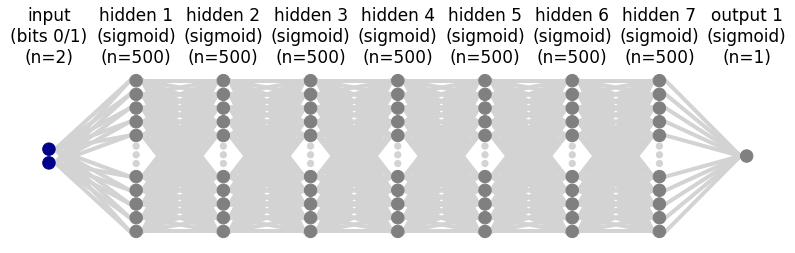

In [137]:
plt.rcParams["figure.figsize"] = (14,10)
# Input layer
layersList = [{"title":"input\n(bits 0/1)"+"\n(n="+str(nInputs)+")", "units": nInputs, "color": "darkBlue"}]
# Hidden layers
if nLayers>1:
    for i in range(nLayers-1):
        layersList.append({"title":"hidden "+str(i+1)+"\n("+activation_func_names[i]+")"+"\n(n="+str(neurons_per_layer[i])+")", "units": neurons_per_layer[i]})
        

# Output layers
layersList.append({"title":"output 1\n("+activation_func_names[nLayers-1]+")"+"\n(n="+str(neurons_per_layer[nLayers-1])+")", "units": neurons_per_layer[nLayers-1]})

NNV(layersList,max_num_nodes_visible=10, node_radius=5, spacing_layer=60, font_size=17).render()
plt.rcParams["figure.figsize"] = (9,6)

## Set inputs

In [138]:
inputs = np.array([[0.,0.,1.,1.],[0.,1.,0.,1.]]).T.astype('float32')
print(inputs)
print(inputs.dtype)


[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
float32


In [139]:
# AND function
outputAND = np.array([0.,0.,0.,1.])
outputAND = np.asarray([outputAND]).T
# OR function
outputOR = np.array([0.,1.,1.,1.])
outputOR = np.asarray([outputOR]).T
# NAND function
outputNAND = np.array([1.,1.,1.,0.])
outputNAND = np.asarray([outputNAND]).T
# XOR function
outputXOR = np.array([0.,1.,1.,0.])
outputXOR = np.asarray([outputXOR]).T

## Set outputs

In [140]:
# outputs = outputAND
# outputs = outputOR
# outputs = outputNAND
outputs = outputXOR
outputs = outputs.astype('float32')
print(outputs)
print(outputs.dtype)

[[0.]
 [1.]
 [1.]
 [0.]]
float32


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [141]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [142]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=activation_func_names[0], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=activation_func_names[i], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=activation_func_names[nLayers-1], use_bias=True))
    
model.summary()
    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 500)               1500      
_________________________________________________________________
dense_16 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_17 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_18 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_19 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_20 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_21 (Dense)             (None, 500)              

## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [143]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 2.42391825e-02 -1.90280378e-04  1.02404729e-01  9.55310911e-02
  -9.79384333e-02  5.15849739e-02  8.32417309e-02 -1.02448910e-02
   6.64193779e-02 -3.18547338e-03  1.40600502e-02 -3.22537273e-02
  -7.10748434e-02 -4.92151417e-02  8.59891772e-02 -4.62049842e-02
  -3.66467088e-02 -7.88822249e-02  1.40983909e-02 -8.58987123e-03
  -2.75894403e-02  7.37750828e-02 -8.07549059e-03 -5.22174314e-02
   2.58084983e-02 -3.93491387e-02 -1.72972679e-03 -6.02303147e-02
  -4.49507684e-03 -1.09250337e-01 -7.07371607e-02 -3.52102965e-02
  -1.08037814e-02 -7.45164305e-02 -5.12298904e-02  2.62195915e-02
   2.90917903e-02 -4.15756702e-02  1.26215294e-02  6.06729537e-02
  -8.39823335e-02  3.95243466e-02 -4.51589525e-02 -1.53122321e-02
   9.98844504e-02  8.18726271e-02 -2.39045992e-02  3.46803069e-02
   7.46634156e-02 -7.82203972e-02 -2.59434581e-02  6.28647655e-02
  -3.77203971e-02 -2.69930884e-02  8.24915171e-02 -7.85859153e-02
  -7.15656504e-02 -7.91634172e-02  1.69228166e-02  3.

## Save the weights generated by tf.keras and use them for our implementation as well

In [144]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[ 2.42391825e-02,  5.73039353e-02],
       [-1.90280378e-04, -4.40124199e-02],
       [ 1.02404729e-01,  8.36470574e-02],
       [ 9.55310911e-02,  8.01077485e-03],
       [-9.79384333e-02,  8.80614370e-02],
       [ 5.15849739e-02, -1.98879316e-02],
       [ 8.32417309e-02, -2.32634470e-02],
       [-1.02448910e-02,  2.66030133e-02],
       [ 6.64193779e-02,  4.29746211e-02],
       [-3.18547338e-03, -7.28692561e-02],
       [ 1.40600502e-02,  8.55819881e-03],
       [-3.22537273e-02, -1.04847267e-01],
       [-7.10748434e-02, -4.47201729e-02],
       [-4.92151417e-02,  9.50963199e-02],
       [ 8.59891772e-02,  8.63923281e-02],
       [-4.62049842e-02, -5.58980182e-02],
       [-3.66467088e-02, -4.33760583e-02],
       [-7.88822249e-02,  9.56471264e-03],
       [ 1.40983909e-02, -1.07034750e-01],
       [-8.58987123e-03,  3.40372324e-03],
       [-2.75894403e-02, -3.70470732e-02],
       [ 7.37750828e-02, -5.20689785e-03],
       [-8.07549059e-03,  2.511315

## Compile model

In [145]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])



## Forward feed

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [146]:
model.evaluate(inputs, outputs, batch_size=nSamples)

4/1 [========================================================================================================================] - 0s 63ms/sample - loss: 0.2727 - mse: 0.2727


[0.2726925015449524, 0.2726925]

## Does tf.model.evaluate change the weights and biases?

In [147]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 2.42391825e-02 -1.90280378e-04  1.02404729e-01  9.55310911e-02
  -9.79384333e-02  5.15849739e-02  8.32417309e-02 -1.02448910e-02
   6.64193779e-02 -3.18547338e-03  1.40600502e-02 -3.22537273e-02
  -7.10748434e-02 -4.92151417e-02  8.59891772e-02 -4.62049842e-02
  -3.66467088e-02 -7.88822249e-02  1.40983909e-02 -8.58987123e-03
  -2.75894403e-02  7.37750828e-02 -8.07549059e-03 -5.22174314e-02
   2.58084983e-02 -3.93491387e-02 -1.72972679e-03 -6.02303147e-02
  -4.49507684e-03 -1.09250337e-01 -7.07371607e-02 -3.52102965e-02
  -1.08037814e-02 -7.45164305e-02 -5.12298904e-02  2.62195915e-02
   2.90917903e-02 -4.15756702e-02  1.26215294e-02  6.06729537e-02
  -8.39823335e-02  3.95243466e-02 -4.51589525e-02 -1.53122321e-02
   9.98844504e-02  8.18726271e-02 -2.39045992e-02  3.46803069e-02
   7.46634156e-02 -7.82203972e-02 -2.59434581e-02  6.28647655e-02
  -3.77203971e-02 -2.69930884e-02  8.24915171e-02 -7.85859153e-02
  -7.15656504e-02 -7.91634172e-02  1.69228166e-02  3.

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [86]:
# fit the keras model on the dataset
model.fit(inputs, outputs, epochs=1, batch_size=nSamples)

Train on 4 samples
4/4 [==============================] - 1s 168ms/sample - loss: 0.2529 - mse: 0.2529


## Now the weights and biases must have been updated

In [87]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.0359872  -0.07253114 -0.10905755 -0.06677728  0.02743448  0.07077006
  -0.10375103 -0.03709761 -0.10461624 -0.0517986   0.05541609 -0.09919055
   0.05428856  0.04143701 -0.03064196 -0.00554375  0.08073363 -0.09921565
  -0.02750687  0.00905731 -0.03742335  0.0496258   0.09149907  0.04157047
   0.01248692 -0.03973269 -0.05476858  0.02474163  0.01394564  0.04731009
   0.10588809 -0.08615146  0.09156111  0.10775545 -0.02296473 -0.02255919
  -0.05879825 -0.06431166  0.00776562 -0.05741113  0.09315462  0.00682727
  -0.05568669 -0.03505385  0.03047771 -0.04038921  0.03887603 -0.10560226
  -0.06085132  0.10009006  0.06515512 -0.0953539  -0.03524556 -0.00794717
   0.09112086 -0.10441852  0.09559838  0.00022488 -0.01078681 -0.02624159
   0.10287705  0.00115048 -0.01624238 -0.03235852  0.10517894 -0.01976549
  -0.03695936 -0.03870126 -0.08790136  0.03857463  0.01821389 -0.02680797
   0.00726391 -0.01987839 -0.0626068   0.07801203  0.04904066  0.02584694
  -0.10740679  

## Now let us do a forward feed again and calculate the loss/error

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [88]:
out = model.evaluate(inputs, outputs, batch_size=nSamples)
print(out)

4/1 [========================================================================================================================] - 0s 1ms/sample - loss: 0.3759 - mse: 0.3759
[0.3758733868598938, 0.3758734]


### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for 10^4 epochs

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [148]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=nSamples, verbose=0)
history = model.fit(inputs, outputs, epochs=nEpochs, batch_size=nSamples, verbose=0)

CPU times: user 5min 1s, sys: 3min 59s, total: 9min 1s
Wall time: 1min 16s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [149]:
history.history

{'loss': [0.2726925015449524,
  0.48981785774230957,
  0.4787358045578003,
  0.41482532024383545,
  0.45163315534591675,
  0.2559819519519806,
  0.42896613478660583,
  0.39152365922927856,
  0.48277151584625244,
  0.44649744033813477,
  0.2731836438179016,
  0.48737776279449463,
  0.47040992975234985,
  0.34739357233047485,
  0.495138555765152,
  0.49316298961639404,
  0.48902374505996704,
  0.47702527046203613,
  0.4085198640823364,
  0.45149731636047363,
  0.250662237405777,
  0.2847127914428711,
  0.49148082733154297,
  0.4849659204483032,
  0.46093761920928955,
  0.2783024311065674,
  0.4875720739364624,
  0.47254249453544617,
  0.3769822120666504,
  0.4837847948074341,
  0.4563075602054596,
  0.25967344641685486,
  0.4417615532875061,
  0.27375733852386475,
  0.48075151443481445,
  0.4411297142505646,
  0.27323251962661743,
  0.4788009524345398,
  0.43022793531417847,
  0.3286206126213074,
  0.49185478687286377,
  0.48662233352661133,
  0.4706557095050812,
  0.3732905685901642,
  

## Now also let us have a look at the predictions for the sake of the tutorial

In [150]:
# make probability predictions with the model
predictions = model.predict(inputs)
print(predictions)

[[0.49999976]
 [0.5000001 ]
 [0.49999988]
 [0.50000024]]


## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [151]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_15_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense_15/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  2
Tensor("dense_15/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  2
Tensor("dense_16/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  3
Tensor("dense_16/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  3
Tensor("dense_17/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  4
Tensor("dense_17/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  4
Tensor("dense_18/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  5
Tensor("dense_18/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  5
Tensor("dense_19/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  6
Tensor("dense_19/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  6
Tensor("dense_20/Identity:0", s

In [152]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_15_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense_15/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  2
Tensor("dense_15/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  2
Tensor("dense_16/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  3
Tensor("dense_16/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  3
Tensor("dense_17/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  4
Tensor("dense_17/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  4
Tensor("dense_18/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  5
Tensor("dense_18/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  5
Tensor("dense_19/Identity:0", shape=(None, 500), dtype=float32)

 Inputs for layer  6
Tensor("dense_19/Identity:0", shape=(None, 500), dtype=float32)

 Outputs for layer  6
Tensor("dense_20/Identity:0", s

## We can't really see any numbers in the above output
## So we need to do something more

In [153]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

 Outputs for layer  1
[[0.49999958 0.5000005  0.5000012  ... 0.5000003  0.5000001  0.4999998 ]
 [0.51432145 0.48899937 0.52090126 ... 0.47567347 0.47796774 0.4973424 ]
 [0.5060589  0.49995315 0.5255805  ... 0.47513813 0.48103702 0.5185057 ]
 [0.52037364 0.48895207 0.54638135 ... 0.45093    0.45907307 0.51585144]]

 Inputs for layer  2
[[0.49999958 0.5000005  0.5000012  ... 0.5000003  0.5000001  0.4999998 ]
 [0.51432145 0.48899937 0.52090126 ... 0.47567347 0.47796774 0.4973424 ]
 [0.5060589  0.49995315 0.5255805  ... 0.47513813 0.48103702 0.5185057 ]
 [0.52037364 0.48895207 0.54638135 ... 0.45093    0.45907307 0.51585144]]

 Outputs for layer  2
[[0.40885162 0.70313126 0.6128084  ... 0.61403304 0.39260277 0.73286253]
 [0.40676257 0.7091681  0.6141043  ... 0.6163595  0.38962182 0.732635  ]
 [0.40761644 0.6973899  0.6134316  ... 0.6070676  0.39073    0.730342  ]
 [0.40553227 0.70348823 0.614722   ... 0.60941124 0.38774514 0.73011

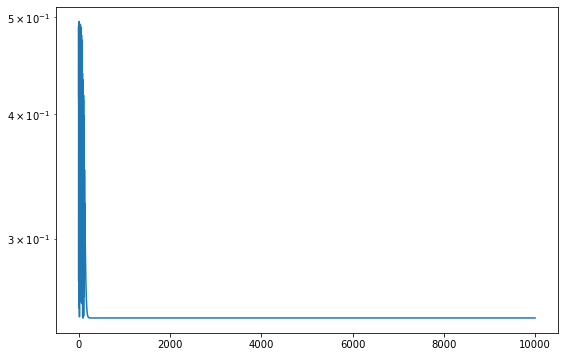

In [154]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Some activation functions and error functions, and their derivatives

In [155]:
@njit(cache=False,fastmath=True)
def tanhAct(x):
    return 0.5*(1+np.tanh(x))

@njit(cache=False,fastmath=True)
def sigmoid(x):
    return 1/(1+np.exp(-x))
#     return ne.evaluate('1/(1+exp(x))')

In [156]:
def activationFunc(x):
    '''
    Activation function
    '''
    scalar_input = False
    x = np.asarray(x)
    if x.ndim == 0:
        x = x[np.newaxis] # Makes x 1D
        scalar_input = True
    return tanhAct(x)
#     return sigmoid(x)

@njit(cache=False,fastmath=True)
def errorFunc(outi, out0):
    '''
    Error function
    out0 is the expected output (exact/ideal)
    outi is the calculated output
    '''
    
    return np.sum((outi-out0)**2)/outi.shape[1]

def errorFunc_(outi, out0):
    '''
    Error function
    out0 is the expected output (exact/ideal)
    outi is the calculated output
    '''
    
    return anp.sum((outi-out0)**2)/outi.shape[1]

@njit(cache=False,fastmath=True)
def errorFuncGrad(outi, out0):
    '''
    Error function
    out0 is the expected output (exact/ideal)
    outi is the calculated output
    '''
    
    return 2*(outi-out0)/outi.shape[1]

## Choose if to use the error function grad defined manually or using the autograd

In [157]:
# Define the gradient of the error function wrt to the predicted output values
gradErrorFunc = grad(errorFunc,0) # Use the autograd library
gradErrorFunc = errorFuncGrad

@njit(cache=False,fastmath=True)
def tanhActFuncPrime(x):
    return 1/(np.cosh(2*x)+1)

@njit(cache=False,fastmath=True)
def sigmoidActFuncPrime(x):
    return np.exp(-x)/(np.exp(-x)+1)**2
#     return ne.evaluate('exp(-x)/(exp(-x)+1)**2')

## Numba function to update weights as that is very slow (doesn't work)

In [158]:
# @njit('float32, (float32[:]),(float32[:]), (float32[:]), (float32[:])',cache=False,fastmath=True, parallel=True)
@njit(cache=False,fastmath=True, parallel=False)
def updateWeightsBiases(eeta, weights, derWeights, biases, derBiases):
    newWeights = weights
    newBiases = biases
    for i in range(nLayers):
#         newWeights[i] = weights[i].astype('float32')-eeta*derWeights[i].astype('float32')
#         newBiases[i] = biases[i].astype('float32')-eeta*derBiases[i].astype('float32')
        newWeights[i] = weights[i]#.astype('float32')-eeta*derWeights[i].astype('float32')
        newBiases[i] = biases[i]#.astype('float32')-eeta*derBiases[i].astype('float32')
    return newWeights, newBiases

## Define forward feed, backpropagation and optimization functions

In [159]:
# @njit(cache=False,fastmath=True)
def forwardFeed(x, nLayers, biases, weights, activationFunc):
    '''
    x: matrix of input arrays of size mxn; m: samples/batch size; n: no. of inputs/features
    biases: 1d array of nLayers biases
    weights: nLayers matrices of weights
    '''
    # Forward feed begin
    a = [None] * (nLayers+1)
    z = [None] * nLayers
    a[0] = x
    for l in range(1,nLayers+1):
        z[l-1] = np.einsum('ij,kj->ik',a[l-1],weights[l-1])+biases[l-1] #np.dot(a[l-1],weights[l-1])#np.asarray(biases[l-1] + np.dot(a[l-1],weights[l-1])) #np.einsum('jk,k->j',weights[l-1],a[l-1])s #weights[l-1]*a[l-1]
#         z[l-1] = contract('ij,kj->ik',a[l-1],weights[l-1])+biases[l-1] #np.dot(a[l-1],weights[l-1])#np.asarray(biases[l-1] + np.dot(a[l-1],weights[l-1])) #np.einsum('jk,k->j',weights[l-1],a[l-1])s #weights[l-1]*a[l-1]
        a[l] = activationFunc(z[l-1])
        
    return a, z

In [160]:
@njit(cache=False,fastmath=True,parallel=True)
def tempEval(a,b,n):
    out = np.empty((n,a.shape[1]),dtype=np.float32)
    for i in prange(n):
        out[i] = np.dot(a.T, b[i,:]).T
    return out

In [161]:
# @njit(cache=False,fastmath=True)
def backPropagation(z, a, sigmaPrime, nLayers, weights, dc_daL):
    '''
    z: list of input vectors (different sizes) at each layer
    a: list of output vectors after the application of act func (different sizes) at each layer
    sigmaPrime: the function that gives the derivative of the activation function
    dc_daL: a vector that gives the derivative of the Cost function wrt to the output
             vector coming out of the output layer
    '''
    nSamples = a[0].shape[0]
    delta = [None] * (nLayers+1)
    derWeights = [None] * nLayers
    derBiases = [None] * nLayers
    delta[nLayers] = sigmaPrime(z[nLayers-1])*dc_daL
    
    derWeights[nLayers-1] = np.einsum('ji,jk->ik',delta[nLayers],a[nLayers-1])
#     derWeights[nLayers-1] = contract('ji,jk->ik',delta[nLayers],a[nLayers-1])
    derBiases[nLayers-1] = np.sum(delta[nLayers],axis=0)
    
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
#         temp = tempEval(np.float32(weights[l]),np.float32(delta[l+1]),nSamples)
#         temp = np.dot(weights[l].T, list(delta[l+1].T)).T # Slower
        delta[l] = sigmaPrime(z[l-1])*temp
        derWeights[l-1] = np.einsum('ji,jk->ik',delta[l],a[l-1])
#         derWeights[l-1] = contract('ji,jk->ik',delta[l],a[l-1])
        derBiases[l-1] = np.asarray(np.sum(delta[l],axis=0))
    return derWeights, derBiases

In [162]:
# @njit(cache=False,fastmath=True)
def backPropagation2(z, a, sigmaPrime, nLayers, weights, dc_daL, opt_einsum_expr):
    '''
    z: list of input vectors (different sizes) at each layer
    a: list of output vectors after the application of act func (different sizes) at each layer
    sigmaPrime: the function that gives the derivative of the activation function
    dc_daL: a vector that gives the derivative of the Cost function wrt to the output
             vector coming out of the output layer
    '''
    nSamples = a[0].shape[0]
    delta = [None] * (nLayers+1)
    derWeights = [None] * nLayers
    derBiases = [None] * nLayers
    delta[nLayers] = sigmaPrime(z[nLayers-1])*dc_daL
    
    derWeights[nLayers-1] = opt_einsum_expr[0](delta[nLayers],a[nLayers-1])
#     derWeights[nLayers-1] = contract('ji,jk->ik',delta[nLayers],a[nLayers-1])
    derBiases[nLayers-1] = np.sum(delta[nLayers],axis=0)
    ioptexpr=1
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
#         temp = tempEval(np.float32(weights[l]),np.float32(delta[l+1]),nSamples)
#         temp = np.dot(weights[l].T, list(delta[l+1].T)).T # Slower
        delta[l] = sigmaPrime(z[l-1])*temp
        derWeights[l-1] = opt_einsum_expr[ioptexpr](delta[l],a[l-1])
        ioptexpr=ioptexpr+1
#         derWeights[l-1] = contract('ji,jk->ik',delta[l],a[l-1])
        derBiases[l-1] = np.asarray(np.sum(delta[l],axis=0))
    return derWeights, derBiases

In [163]:
# @njit(cache=False,fastmath=True)
def backPropagation3(z, a, sigmaPrime, nLayers, weights, biases, eeta, dc_daL):
    '''
    z: list of input vectors (different sizes) at each layer
    a: list of output vectors after the application of act func (different sizes) at each layer
    sigmaPrime: the function that gives the derivative of the activation function
    dc_daL: a vector that gives the derivative of the Cost function wrt to the output
             vector coming out of the output layer
    '''
    nSamples = a[0].shape[0]
    delta = [None] * (nLayers+1)
    derWeights = [None] * nLayers
    derBiases = [None] * nLayers
    delta[nLayers] = sigmaPrime(z[nLayers-1])*dc_daL
    
    newWeights = weights[:]#.copy()
    newBiases = biases[:]#.copy()
    
    derWeights[nLayers-1] = np.einsum('ji,jk->ik',delta[nLayers],a[nLayers-1])
    newWeights[nLayers-1] = weights[nLayers-1] - eeta*derWeights[nLayers-1]
#     derWeights[nLayers-1] = contract('ji,jk->ik',delta[nLayers],a[nLayers-1])
    derBiases[nLayers-1] = np.sum(delta[nLayers],axis=0)
    newBiases[nLayers-1] = biases[nLayers-1] - eeta*derBiases[nLayers-1]
    
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
#         temp = tempEval(np.float32(weights[l]),np.float32(delta[l+1]),nSamples)
#         temp = np.dot(weights[l].T, list(delta[l+1].T)).T # Slower
        delta[l] = sigmaPrime(z[l-1])*temp
        derWeights[l-1] = np.einsum('ji,jk->ik',delta[l],a[l-1])
#         derWeights[l-1] = contract('ji,jk->ik',delta[l],a[l-1])
        derBiases[l-1] = np.asarray(np.sum(delta[l],axis=0))
        newWeights[l-1] = weights[l-1] - eeta*derWeights[l-1] 
        newBiases[l-1] = biases[l-1] - eeta*derBiases[l-1]
    return derWeights, derBiases, newWeights, newBiases

In [164]:
# @njit(cache=False,fastmath=True)
def backPropagation4(z, a, sigmaPrime, nLayers, weights, biases, eeta, dc_daL, opt_einsum_expr):
    '''
    z: list of input vectors (different sizes) at each layer
    a: list of output vectors after the application of act func (different sizes) at each layer
    sigmaPrime: the function that gives the derivative of the activation function
    dc_daL: a vector that gives the derivative of the Cost function wrt to the output
             vector coming out of the output layer
    '''
    nSamples = a[0].shape[0]
    delta = [None] * (nLayers+1)
    derWeights = [None] * nLayers
    derBiases = [None] * nLayers
    delta[nLayers] = sigmaPrime(z[nLayers-1])*dc_daL
    
    newWeights = weights[:]#.copy()
    newBiases = biases[:]#.copy()
    
    derWeights[nLayers-1] = opt_einsum_expr[0](delta[nLayers],a[nLayers-1])
#     derWeights[nLayers-1] = contract('ji,jk->ik',delta[nLayers],a[nLayers-1])
    newWeights[nLayers-1] = weights[nLayers-1] - eeta*derWeights[nLayers-1]
    derBiases[nLayers-1] = np.sum(delta[nLayers],axis=0)
    newBiases[nLayers-1] = biases[nLayers-1] - eeta*derBiases[nLayers-1]
    ioptexpr=1
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
#         temp = tempEval(np.float32(weights[l]),np.float32(delta[l+1]),nSamples)
#         temp = np.dot(weights[l].T, list(delta[l+1].T)).T # Slower
        delta[l] = sigmaPrime(z[l-1])*temp
        derWeights[l-1] = opt_einsum_expr[ioptexpr](delta[l],a[l-1])
        ioptexpr=ioptexpr+1
#         derWeights[l-1] = contract('ji,jk->ik',delta[l],a[l-1])
        derBiases[l-1] = np.asarray(np.sum(delta[l],axis=0))
        newWeights[l-1] = weights[l-1] - eeta*derWeights[l-1] 
        newBiases[l-1] = biases[l-1] - eeta*derBiases[l-1]
    
    return derWeights, derBiases, newWeights, newBiases

In [165]:
def generateExpressions(nLayers, z, a, dc_daL, sigmaPrime, weights):
    delta = [None] * (nLayers+1)
    opt_einsum_expr = []
    delta[nLayers] = sigmaPrime(z[nLayers-1])*dc_daL
    opt_einsum_expr.append(contract_expression('ji,jk->ik',delta[nLayers].shape,a[nLayers-1].shape))
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
        delta[l] = sigmaPrime(z[l-1])*temp
        opt_einsum_expr.append(contract_expression('ji,jk->ik',delta[l].shape,a[l-1].shape))
    return opt_einsum_expr

In [166]:
# @njit(cache=False,fastmath=True)
def neuralNetworkOptimize(nEpochs, nSamples, eeta, inputs, outputs, weights, biases, activationFunc, sigmaPrime, nLayers, errorFunc, gradErrorFunc, isPlot=False):
    errorPlot=[]
    forwardFeedDuration = 0.0
    backPropDuration = 0.0
    updateWeightsDuration = 0.0
    gradErrorDuration = 0.0
    for iEpoch in tqdm(range(nEpochs),leave=True,miniters=100):
        x = inputs# Input vector
    #         print('Inputs: ',x)
        outExpected = outputs # Expected output
    #         print(outExpected)
#         start = timer()
            # Perform Forward feed and get the outputs at each layers and the inputs at each layer
        a, z = forwardFeed(x, nLayers, biases, weights, activationFunc)
#         forwardFeedDuration = forwardFeedDuration + timer() - start
    #         print('Inputs at each layer :\n ', z)
    #         print('Outputs at each layer (including input layer):\n ',a)
        
        # Error
        error = errorFunc(a[nLayers],outExpected)
    #         print('Error:\n', errorFunc(a[nLayers],outExpected))
        # Get the derivative of the output cost function wrt to the output vector of the output layer
        # The input arguments should always be an array
#         start = timer()
        dc_daL = gradErrorFunc(a[nLayers], outExpected)
        # Average it out
        dc_daL = dc_daL/nSamples
#         gradErrorDuration = gradErrorDuration + timer() - start
    #         print(dc_daL)
    #         print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)
            # Perform Back Propagation and get the derivatives wrt the weights and biases
#         start = timer()
        derWeights, derBiases, weights, biases = backPropagation3(z, a, sigmaPrime, nLayers, weights, biases, eeta, dc_daL)
#         backPropDuration = backPropDuration + timer() - start
    #         print('Gradient of Cost (error function) wrt weights:\n',derWeights)
    #         print('Gradient of Cost (error function) wrt biases:\n',derBiases)
            
    #         print(derWeightsi)


        
        errorPlot.append(error)
        
        if(iEpoch==0):
            print('Average Error with initial weights and biases:', error/nSamples)
    
    
        
#         newWeights = [weights[i] - eeta*derWeights[i] for i in range(nLayers)]
#         newBiases = [biases[i] - eeta*derBiases[i] for i in range(nLayers)]
#         weights = newWeights
#          # Comment out the following line to not optimize biases
#         biases = newBiases
#         weights, biases = updateWeightsBiases(eeta, weights, derWeights, biases, derBiases)
#         weights = ak.to_list(ak.Array(weights) - eeta*ak.Array(derWeights))
#         biases = ak.to_list(ak.Array(biases) - eeta*ak.Array(derBiases))
        
        
    print(forwardFeedDuration)
    print(backPropDuration)
    print(updateWeightsDuration)
    print(gradErrorDuration)
    return weights, biases, errorPlot

In [167]:
# @njit(cache=False,fastmath=True)
def neuralNetworkOptimize2(nEpochs, nSamples, eeta, inputs, outputs, weights, biases, activationFunc, sigmaPrime, nLayers, errorFunc, gradErrorFunc, isPlot=False):
    errorPlot=[]
    for iEpoch in tqdm(range(nEpochs),leave=True,miniters=100):
        x = inputs# Input vector
    #         print('Inputs: ',x)
        outExpected = outputs # Expected output
    #         print(outExpected)
            # Perform Forward feed and get the outputs at each layers and the inputs at each layer
        a, z = forwardFeed(x, nLayers, biases, weights, activationFunc)
    #         print('Inputs at each layer :\n ', z)
    #         print('Outputs at each layer (including input layer):\n ',a)
        
        # Error
        error = errorFunc(a[nLayers],outExpected)
    #         print('Error:\n', errorFunc(a[nLayers],outExpected))
        # Get the derivative of the output cost function wrt to the output vector of the output layer
        # The input arguments should always be an array
        dc_daL = gradErrorFunc(a[nLayers], outExpected)
        # Average it out
        dc_daL = dc_daL/nSamples
        if iEpoch==0:
            opt_expr = generateExpressions(nLayers, z, a, dc_daL, sigmaPrime, weights)
    #         print(dc_daL)
    #         print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)
            # Perform Back Propagation and get the derivatives wrt the weights and biases
        derWeights, derBiases, weights, biases = backPropagation4(z, a, sigmaPrime, nLayers, weights, biases, eeta, dc_daL,opt_expr)
    #         print('Gradient of Cost (error function) wrt weights:\n',derWeights)
    #         print('Gradient of Cost (error function) wrt biases:\n',derBiases)
            
    #         print(derWeightsi)


        
        errorPlot.append(error)
        
        if(iEpoch==0):
            print('Average Error with initial weights and biases:', error/nSamples)
    
    
    
#         newWeights = [weights[i] - eeta*derWeights[i] for i in range(nLayers)]
#         newBiases = [biases[i] - eeta*derBiases[i] for i in range(nLayers)]
#         weights = newWeights
#         biases = newBiases
        
        
    return weights, biases, errorPlot

## Forwad feed once

In [168]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forwardFeed(inputs, nLayers, biasesOriginal, weightsOriginal, sigmoid)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', errorFunc(a[nLayers],outputs)/nBatch)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.51432204, 0.48899868, 0.5208996 , ..., 0.4756729 , 0.4779675 ,
        0.49734274],
       [0.5060595 , 0.49995244, 0.52557886, ..., 0.47513756, 0.48103678,
        0.518506  ],
       [0.5203745 , 0.48895115, 0.54637927, ..., 0.4509292 , 0.4590727 ,
        0.51585186]], dtype=float32), array([[0.40876952, 0.7031174 , 0.61339206, ..., 0.61404085, 0.39272693,
        0.73270875],
       [0.40668058, 0.70915425, 0.61468714, ..., 0.61636734, 0.3897457 ,
        0.7324812 ],
       [0.4075343 , 0.6973757 , 0.614015  , ..., 0.6070755 , 0.39085403,
        0.73018724],
       [0.40545022, 0.7034742 , 0.61530465, ..., 0.60941935, 0.38786882,
        0.72996235]], dtype=float32), array([[0.66644245, 0.45627275, 0.64225215, ..., 0.25798023, 0.52726334,
      

## Backpropagation

In [169]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = gradErrorFunc(a[nLayers], outputs)/nBatch
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases = backPropagation(z, a, sigmoidActFuncPrime, nLayers, weightsOriginal, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[ 0.17467952]
 [-0.32531995]
 [-0.32532036]
 [ 0.17468016]]
Gradient of Cost (error function) wrt weights:
 [array([[ 1.14987149e-08,  1.17762369e-08],
       [ 1.00428139e-07,  9.96612926e-08],
       [-7.61045200e-08, -7.59897816e-08],
       [-7.78456410e-09, -8.33393798e-09],
       [ 9.47284065e-08,  9.41773663e-08],
       [-1.76264663e-07, -1.75104063e-07],
       [-1.40472991e-07, -1.40339381e-07],
       [ 8.48901891e-08,  8.43930508e-08],
       [ 4.04410416e-09,  3.83192456e-09],
       [ 5.89637210e-08,  5.93640692e-08],
       [-1.01949752e-07, -1.00927608e-07],
       [-3.43224293e-08, -3.36474137e-08],
       [ 6.17396889e-09,  6.43304343e-09],
       [ 1.41158474e-09,  7.80876808e-10],
       [-4.65553960e-08, -4.51678837e-08],
       [-5.34693498e-08, -5.36688489e-08],
       [-2.86871575e-08, -2.94346982e-08],
       [-7.74196138e-08, -7.84428948e-08],
       [ 2.66593538e-08,  2.62304347

      dtype=float32), array([-0.06848334], dtype=float32)]


## Gradient descent (update the weights and biases)

In [170]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 2.42391769e-02,  5.73039278e-02],
       [-1.90330597e-04, -4.40124683e-02],
       [ 1.02404766e-01,  8.36470947e-02],
       [ 9.55310985e-02,  8.01077858e-03],
       [-9.79384780e-02,  8.80613923e-02],
       [ 5.15850633e-02, -1.98878441e-02],
       [ 8.32417980e-02, -2.32633762e-02],
       [-1.02449339e-02,  2.66029704e-02],
       [ 6.64193779e-02,  4.29746173e-02],
       [-3.18550295e-03, -7.28692859e-02],
       [ 1.40601015e-02,  8.55824910e-03],
       [-3.22537087e-02, -1.04847252e-01],
       [-7.10748434e-02, -4.47201766e-02],
       [-4.92151417e-02,  9.50963199e-02],
       [ 8.59891996e-02,  8.63923505e-02],
       [-4.62049581e-02, -5.58979921e-02],
       [-3.66466939e-02, -4.33760434e-02],
       [-7.88821876e-02,  9.56475176e-03],
       [ 1.40983779e-02, -1.07034765e-01],
       [-8.58982280e-03,  3.40377190e-03],
       [-2.75894944e-02, -3.70471254e-02],
       [ 7.37750903e-02, -5.20689366e-03],
       [-8.07548221e-03,  2.51131598e-0

## Forward feed again and check the loss/error

In [171]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forwardFeed(inputs, nLayers, newBiases, newWeights, sigmoid)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', errorFunc(a[nLayers],outputs)/nBatch)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.49999997, 0.5       , ..., 0.5       , 0.49999997,
        0.49999997],
       [0.51432204, 0.48899862, 0.5208996 , ..., 0.4756729 , 0.4779675 ,
        0.49734268],
       [0.5060595 , 0.49995238, 0.52557886, ..., 0.47513756, 0.48103675,
        0.518506  ],
       [0.5203745 , 0.4889511 , 0.54637927, ..., 0.45092916, 0.45907265,
        0.5158518 ]], dtype=float32), array([[0.40876892, 0.7031174 , 0.61339736, ..., 0.614049  , 0.39271766,
        0.73269004],
       [0.40668008, 0.7091542 , 0.6146924 , ..., 0.6163755 , 0.38973635,
        0.73246235],
       [0.40753382, 0.6973757 , 0.6140202 , ..., 0.6070838 , 0.39084473,
        0.73016834],
       [0.40544996, 0.70347416, 0.61530995, ..., 0.60942745, 0.38785958,
        0.7299433 ]], dtype=float32), array([[0.6663688 , 0.4563494 , 0.6423021 , ..., 0.2579467 , 0.5272088 ,
      

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [172]:
%%time
# Run optimization
optWeightsAND, optBiasesAND, errorPlot = neuralNetworkOptimize(nEpochs, nSamples, eeta, inputs, outputs, weightsOriginal, biasesOriginal, sigmoid, sigmoidActFuncPrime, nLayers, errorFunc, gradErrorFunc, isPlot=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.2726925015449524
0.0
0.0
0.0
0.0
CPU times: user 1min 10s, sys: 420 ms, total: 1min 11s
Wall time: 1min 11s


#### Test the quality of the weights by running a forward feed again

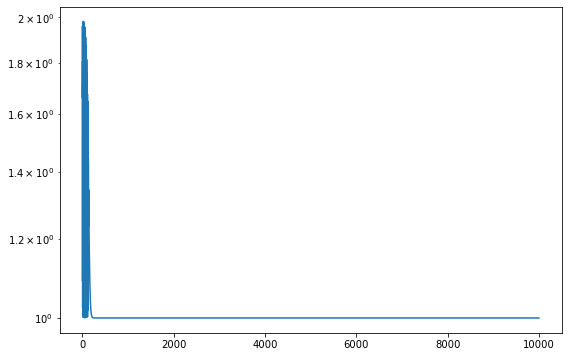

In [173]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [174]:
# Optimized weights and biases
print('Optimized Weights: ', optWeightsAND)
print('Optimized Biases: ', optBiasesAND)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forwardFeed(inputs, nLayers, optBiasesAND, optWeightsAND, sigmoid)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', errorFunc(a[nLayers],outputs)/nBatch)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 2.42383238e-02,  5.73030524e-02],
       [-1.89236074e-04, -4.40114774e-02],
       [ 1.02406651e-01,  8.36489648e-02],
       [ 9.55312625e-02,  8.01110361e-03],
       [-9.79387388e-02,  8.80611315e-02],
       [ 5.15853390e-02, -1.98876467e-02],
       [ 8.32423344e-02, -2.32628360e-02],
       [-1.02447513e-02,  2.66031679e-02],
       [ 6.64174259e-02,  4.29726355e-02],
       [-3.18617583e-03, -7.28699863e-02],
       [ 1.40610728e-02,  8.55917018e-03],
       [-3.22534256e-02, -1.04846977e-01],
       [-7.10763931e-02, -4.47217189e-02],
       [-4.92125563e-02,  9.50989127e-02],
       [ 8.59873444e-02,  8.63904580e-02],
       [-4.62040417e-02, -5.58970720e-02],
       [-3.66463736e-02, -4.33757119e-02],
       [-7.88819194e-02,  9.56504699e-03],
       [ 1.40983434e-02, -1.07034773e-01],
       [-8.58892873e-03,  3.40466201e-03],
       [-2.75877938e-02, -3.70454043e-02],
       [ 7.37769753e-02, -5.20494487e-03],
       [-8.07529967e-03,  2.51133

In [175]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeightsAND[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiasesAND[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
8.940697e-08
7.023914e-09

Layer :  2
1.7136335e-07
1.7798811e-08

Layer :  3
2.0116568e-07
9.397081e-08

Layer :  4
3.6507845e-07
3.872483e-07

Layer :  5
1.0058284e-06
1.2932578e-06

Layer :  6
4.8950315e-06
5.8995793e-06

Layer :  7
1.7166138e-05
6.9243833e-06

Layer :  8
0.00020208582
0.001083184


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [195]:
%%time
# Run optimization
optWeightsAND, optBiasesAND, errorPlot = neuralNetworkOptimize2(nEpochs, nSamples, eeta, inputs, outputs, weightsOriginal, biasesOriginal, sigmoid, sigmoidActFuncPrime, nLayers, errorFunc, gradErrorFunc, isPlot=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.2726925015449524
CPU times: user 59.8 s, sys: 364 ms, total: 1min
Wall time: 1min


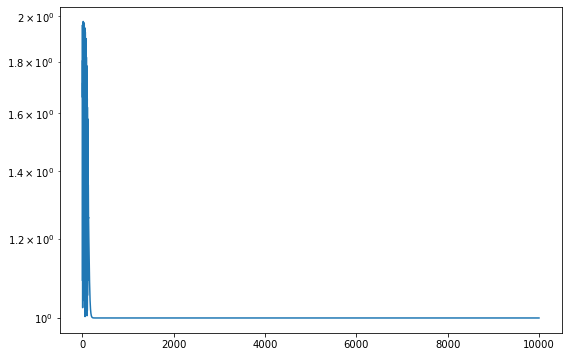

In [177]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [178]:
# Optimized weights and biases
print('Optimized Weights: ', optWeightsAND)
print('Optimized Biases: ', optBiasesAND)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forwardFeed(inputs, nLayers, optBiasesAND, optWeightsAND, sigmoid)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', errorFunc(a[nLayers],outputs)/nBatch)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 2.42383219e-02,  5.73030785e-02],
       [-1.89236758e-04, -4.40114848e-02],
       [ 1.02406643e-01,  8.36489499e-02],
       [ 9.55312401e-02,  8.01109429e-03],
       [-9.79387909e-02,  8.80611092e-02],
       [ 5.15853167e-02, -1.98876560e-02],
       [ 8.32423493e-02, -2.32628398e-02],
       [-1.02447541e-02,  2.66031604e-02],
       [ 6.64174035e-02,  4.29726280e-02],
       [-3.18617490e-03, -7.28699863e-02],
       [ 1.40610691e-02,  8.55917297e-03],
       [-3.22534256e-02, -1.04846962e-01],
       [-7.10763857e-02, -4.47217040e-02],
       [-4.92125414e-02,  9.50988755e-02],
       [ 8.59873667e-02,  8.63904804e-02],
       [-4.62040417e-02, -5.58970645e-02],
       [-3.66463810e-02, -4.33757007e-02],
       [-7.88819268e-02,  9.56505816e-03],
       [ 1.40983500e-02, -1.07034765e-01],
       [-8.58891569e-03,  3.40466062e-03],
       [-2.75877882e-02, -3.70453745e-02],
       [ 7.37769231e-02, -5.20494441e-03],
       [-8.07529502e-03,  2.51133

In [179]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeightsAND[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiasesAND[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
1.0430813e-07
6.893515e-09

Layer :  2
1.5646219e-07
1.0054464e-08

Layer :  3
2.256711e-07
5.3300028e-08

Layer :  4
3.3527613e-07
2.2116001e-07

Layer :  5
6.854534e-07
8.2416955e-07

Layer :  6
3.8295984e-06
4.8754737e-06

Layer :  7
1.7605722e-05
1.8077902e-05

Layer :  8
0.00014960766
0.0007659495


# PyTorch

In [180]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [181]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [182]:
Network = torch.nn.Sequential(*Layers)

In [183]:
print(Network)

Sequential(
  (0): Linear(in_features=2, out_features=500, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): Sigmoid()
  (14): Linear(in_features=500, out_features=1, bias=True)
  (15): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [184]:
Network = torch.nn.Sequential()

# Input layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
Network.add_module('act0',torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),torch.nn.Sigmoid())
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),torch.nn.Sigmoid())

In [185]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=2, out_features=500, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=500, out_features=500, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (act2): Sigmoid()
  (3): Linear(in_features=500, out_features=500, bias=True)
  (act3): Sigmoid()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (act4): Sigmoid()
  (5): Linear(in_features=500, out_features=500, bias=True)
  (act5): Sigmoid()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (act6): Sigmoid()
  (7): Linear(in_features=500, out_features=1, bias=True)
  (act7): Sigmoid()
)

## initial weights and biases generated by Pytorch

In [186]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[ 3.3395e-01,  5.7248e-01],
        [-1.6466e-01,  4.1628e-01],
        [ 1.1406e-01,  5.2066e-01],
        [ 1.3772e-01, -1.1584e-01],
        [ 1.8255e-02, -2.9266e-01],
        [ 4.7040e-01, -6.5020e-01],
        [ 4.6677e-01,  6.3726e-01],
        [ 1.6424e-01,  2.5012e-01],
        [-2.8858e-01, -5.0293e-01],
        [-2.2865e-01, -6.0724e-01],
        [ 1.9943e-01, -6.4450e-01],
        [-2.1825e-01, -7.6951e-02],
        [ 3.7968e-01,  1.8042e-01],
        [ 2.9326e-01, -2.2769e-01],
        [-6.5424e-01,  4.5863e-01],
        [-2.9665e-01,  3.4511e-01],
        [-9.9360e-02,  5.1358e-01],
        [-5.7710e-01, -7.0426e-01],
        [-1.8703e-01, -7.7964e-02],
        [-3.7156e-01,  5.2622e-01],
        [ 1.5992e-01,  4.2230e-01],
        [ 2.5478e-01, -1.1933e-01],
        [ 5.3005e-01, -2.4094e-01],
        [ 1.3560e-01,  3.7917e-01],
        [-4.4981e-01,  6.7932e-01],
        [ 1.0772e-01, -1.7146e-01],
        [ 1.4428e-01,  2.1600e-01],
      

## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [187]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [188]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[ 2.4239e-02,  5.7304e-02],
        [-1.9028e-04, -4.4012e-02],
        [ 1.0240e-01,  8.3647e-02],
        [ 9.5531e-02,  8.0108e-03],
        [-9.7938e-02,  8.8061e-02],
        [ 5.1585e-02, -1.9888e-02],
        [ 8.3242e-02, -2.3263e-02],
        [-1.0245e-02,  2.6603e-02],
        [ 6.6419e-02,  4.2975e-02],
        [-3.1855e-03, -7.2869e-02],
        [ 1.4060e-02,  8.5582e-03],
        [-3.2254e-02, -1.0485e-01],
        [-7.1075e-02, -4.4720e-02],
        [-4.9215e-02,  9.5096e-02],
        [ 8.5989e-02,  8.6392e-02],
        [-4.6205e-02, -5.5898e-02],
        [-3.6647e-02, -4.3376e-02],
        [-7.8882e-02,  9.5647e-03],
        [ 1.4098e-02, -1.0703e-01],
        [-8.5899e-03,  3.4037e-03],
        [-2.7589e-02, -3.7047e-02],
        [ 7.3775e-02, -5.2069e-03],
        [-8.0755e-03,  2.5113e-02],
        [-5.2217e-02,  4.0902e-02],
        [ 2.5808e-02, -3.7840e-02],
        [-3.9349e-02,  4.4560e-02],
        [-1.7297e-03, -5.1432e-02],
        [-6.0230e-

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [189]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.BCELoss()
# opt = torch.optim.SGD(Network.parameters(), lr=0.2)

crit = torch.nn.MSELoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=2, out_features=500, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=500, out_features=500, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (act2): Sigmoid()
  (3): Linear(in_features=500, out_features=500, bias=True)
  (act3): Sigmoid()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (act4): Sigmoid()
  (5): Linear(in_features=500, out_features=500, bias=True)
  (act5): Sigmoid()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (act6): Sigmoid()
  (7): Linear(in_features=500, out_features=1, bias=True)
  (act7): Sigmoid()
)
1505001 trainable parameters


In [190]:
inputsTorch = torch.from_numpy(inputs)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [191]:
print(inputsTorch)
print(labels)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [192]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs)
errorPlot = []
### Train the model
for e in tqdm(epochs,leave=True,miniters=100):
    tr_loss = 0.
    samples = 0
    
    opt.zero_grad() # zero gradient values
    inputsTorch = inputsTorch.to(device=device) # move input and label tensors to the device with the model
    labels = labels.to(device=device)
    outputsTorch = Network(inputsTorch) # compute model outputs
    loss = crit(outputsTorch, labels) # compute batch loss
    loss.backward() # back-propagate the gradients
    opt.step() # update the model weights
    tr_loss += loss.clone().cpu().item()*len(inputsTorch) # add the batch loss to the running loss
    samples += len(inputsTorch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
#     print(e, tr_loss)

  0%|          | 0/9999 [00:00<?, ?it/s]

CPU times: user 1min 22s, sys: 6.23 s, total: 1min 28s
Wall time: 1min 4s


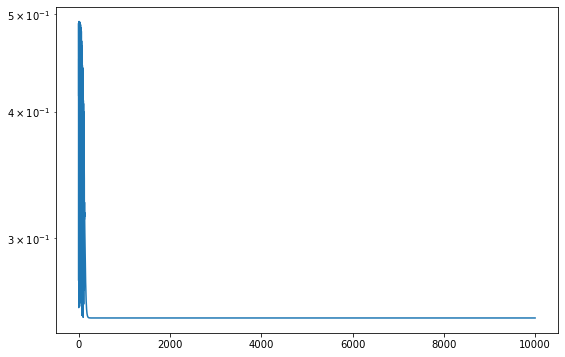

In [193]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [194]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeightsAND[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiasesAND[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(1.0431e-07)
tensor(6.6849e-09)

Layer :  2
tensor(1.4156e-07)
tensor(1.0079e-08)

Layer :  3
tensor(2.4046e-07)
tensor(4.8341e-08)

Layer :  4
tensor(2.3842e-07)
tensor(2.1802e-07)

Layer :  5
tensor(7.5251e-07)
tensor(8.1869e-07)

Layer :  6
tensor(3.9749e-06)
tensor(4.9602e-06)

Layer :  7
tensor(2.3499e-05)
tensor(2.3691e-05)

Layer :  8
tensor(0.0002)
tensor(0.0006)


In [73]:
torch.get_num_threads()

4

In [1578]:
torch.set_num_threads(4)
torch.get_num_threads()

1

In [1579]:
torch.get_num_threads()

1